# Analyse the behavior of the AW in CREG025.L75-OFFTRC experiment

In [3]:
import xarray as xr
import pandas as pd
import numpy as np
from netCDF4 import Dataset
import matplotlib.pylab as plt
import matplotlib as mpl
from matplotlib import rcParams
from mpl_toolkits.basemap import Basemap
from fsspec.implementations.local import LocalFileSystem
fs = LocalFileSystem()

%matplotlib inline

In [1]:
from kerchunk.hdf import SingleHdf5ToZarr 
from kerchunk.combine import MultiZarrToZarr

import fsspec
import json
import intake

import dask
import dask_hpcconfig
from distributed import Client
from dask.distributed import Client, LocalCluster


In [2]:
cluster = dask_hpcconfig.cluster("datarmor", **{})
client = Client(cluster)
cluster.scale(jobs=3)

/home1/datawork/ctalandi/conda-env/Jupyter-Dask/lib/python3.11/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)


>> Function definition START

In [4]:
def Arc_Bat(ztype='isol1000') :

        locpath='/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG12.L75/GRID/'
        locfile='bathymetry_CREG12_V3.3_CT20180612Larger_ct20190102.nc'
        fieldbat=Dataset(locpath+locfile)
        lon  = np.squeeze(fieldbat.variables['nav_lon'])
        lat  = np.squeeze(fieldbat.variables['nav_lat'])
        My_var = np.squeeze(fieldbat.variables['Bathymetry'])

        spval = 0.
        My_var= np.ma.masked_where(My_var <= spval,My_var)

        if ztype == 'isol1000' :
                vmin=1000. ; vmax=2000.
                contours=[1000.]
                limits=[vmin,vmax]
                myticks=[1000.]
        elif ztype == 'isol1500' :
                vmin=1500. ; vmax=2000.
                contours=[1500.]
                limits=[vmin,vmax]
                myticks=[1500.]
        elif ztype == 'isomonarc' :
                vmin=500. ; vmax=4000.
                contours=[500.,2000.,4000.]
                limits=[vmin,vmax]
                myticks=[500.,2000.,4000.]
        elif ztype == 'isol500' :
                vmin=500. ; vmax=500.
                contours=[500.]
                limits=[vmin,vmax]
                myticks=[500.]
        else:
                vmin=0. ; vmax=8000.
                contours=[100.,500.,1000.,2000.,3000.,3500.,4000.]
                limits=[vmin,vmax]
                myticks=[100.,500.,1000.,2000.,3000.,3500.,4000.]

        #
        #rcParams['text.latex.unicode']=True
        plt.rcParams['contour.negative_linestyle'] = 'solid'
        #
        m = Basemap(projection='npstere',boundinglat=65,lon_0=-60, resolution='i')
        norm = mpl.colors.Normalize(vmin=limits[0], vmax=limits[1])
        pal = plt.cm.get_cmap('binary')
        X,Y = m(lon,lat)

        # contour (optional)
        CS2 = m.contour(X, Y, My_var, linewidths=0.5,levels=contours, colors='black', alpha=1.)
        plt.clabel(CS2, CS2.levels, inline=True, fmt='%.0f', fontsize=3)

        return m, X, Y


In [5]:
def Arc_plot(lon,lat,tab,contours,limits,myticks=None,name=None,zmy_cblab=None,zmy_cmap=None,filename='test.pdf',zvar=None):
        #
# Les 2 lignes suivantes posent un probleme a l'execution lie a LaTex ....
#       rcParams['text.usetex']=True
#       rcParams['text.latex.unicode']=True
        #rcParams['font.family']='serif'

        plt.rcParams['contour.negative_linestyle'] = 'solid'
        #
        m = Basemap(projection='npstere',boundinglat=65,lon_0=-60, resolution='i')

        if zvar == 'sivolu' or zvar == 'siconc'  or zvar == 'ssh' or zvar == 'socurl' :
                zfontsize=10.
        else:
                zfontsize=6.

        if zvar != 'Bathy' :
                m.drawparallels(np.arange(-90.,91.,5.),labels=[False,False,False,False], size=zfontsize, linewidth=0.3)
                m.drawmeridians(np.arange(-180.,181.,20.),labels=[True,False,False,True], size=zfontsize, latmax=90.,linewidth=0.3)
                m.fillcontinents(color='grey',lake_color='white')

        norm = mpl.colors.Normalize(vmin=limits[0], vmax=limits[1])

        if zmy_cmap != None :
                pal = zmy_cmap
        else:
                pal = plt.cm.get_cmap('coolwarm')
                #pal = plt.cm.get_cmap('terrain')

        X,Y = m(lon,lat)
        C = m.contourf(X,Y,tab,contours,cmap=pal,norm=norm,extend='both')
        if zvar == 'ssh':
                CS=m.contour(X, Y, tab, linewidths=0.5, levels=npy.arange(limits[0],limits[1],5.), colors='k', alpha=0.4)

        ############################################################################################################
        ############################################################################################################
        moorplot=1
        if moorplot == 1 :
                bx_ARCB={'name':'B'  ,'lon_min':-150.,'lon_max':-150.,'lat_min':78.,'lat_max':78.}
                bx_ARCM={'name':'M1' ,'lon_min': 125.,'lon_max': 125.,'lat_min':78.,'lat_max':78.}
                bx_EURA={'name':'EUR','lon_min':  60.,'lon_max':  60.,'lat_min':85.,'lat_max':85.}

                All_box=[bx_ARCB,bx_EURA]
                for box in All_box:
                        lats = [box['lat_min'],box['lat_max']]
                        lons = [box['lon_min'],box['lon_max']]
                        x,y = m(lons,lats)
                        m.scatter(x,y,3,marker='o', color='r')
                        #m.plot(x,y,linewidth=2, color='g')
        ############################################################################################################
        ############################################################################################################

        # colorbar      
        if myticks is None:
                cbar = plt.colorbar(C,format='%.2f',orientation='vertical',shrink=0.8)
        else:
                if zvar == 'votemper' or zvar == 'vosaline' or zvar == 'sivolu' :
                        cbar = plt.colorbar(C,format='%.2f',orientation='vertical',shrink=0.8,drawedges=True)
                else:
                        cbar = plt.colorbar(C,format='%.0f',orientation='vertical',shrink=0.8,drawedges=True)

                cbar.set_label(zmy_cblab,fontsize=zfontsize)
                cl = plt.getp(cbar.ax, 'ymajorticklabels')
                plt.setp(cl, fontsize=zfontsize)

        plt.title(name,fontsize=zfontsize)

        return

In [6]:
def awtmax_depth (temp,sal,zdim,deptht,ztime=None, zmask=None):
    #%%time 
    if ztime != None : 
        mask = (sal > 33.5) 
        ztemp = temp.where(mask)

    #%%time 
    temp_filled = (ztemp.fillna(-10)).compute() #replace nans with absurd temperature values
    depth_map = temp_filled.argmax(dim=zdim,skipna=True) 
    temp_map = temp_filled.max(dim=zdim,skipna=True)

    temp_map=temp_map.where(temp_map != -10)
    depth_map=depth_map.where(depth_map != -10)
    #print(zmask.shape)
    if zmask.any != None : depth_map=depth_map.where(zmask != 0)
    
    # Need to get now the true depth, not the index
    ind_awdepth=np.int32(depth_map)
    new_depth=[]
    for it in ind_awdepth.flat:
        if it < 0 :
            new_depth.append(-999)
        else:
            new_depth.append(deptht[it])

    true_depth=np.array(new_depth)
    true_depth=np.where(true_depth == -999,np.nan, true_depth)
    # Hard coded dimensions of the CREG12.L75 configuration 
    #reshape_true_depth=np.reshape(true_depth,(1801, 1580))
    # Hard coded dimensions of the CREG025.L75 configuration 
    if ztime != None : 
        reshape_true_depth=np.reshape(true_depth,(ztime,603, 528))
        # Transform the numpy array into a data array
        final_true_depth=xr.DataArray(reshape_true_depth,dims=['time_counter','y','x'])
    else: 
        reshape_true_depth=np.reshape(true_depth,(603, 528))
        # Transform the numpy array into a data array
        final_true_depth=xr.DataArray(reshape_true_depth,dims=['y','x'])

    
    return temp_map, final_true_depth

In [7]:
def ArcticZoom_map(zyear,infld,zmy_min=-10,zmy_max=10,CASE=None,zmap='Spectral_r'):
    # Plot the 12 months of a given year 

    fig, axes = plt.subplots(3, 4, figsize=(20,15)) 

    for i, ax in enumerate(axes.flat):
        if i < 9: 
            mm='0'+str(i+1) 
        else : 
            mm=str(i+1)
        infld.isel(time_counter=i).isel(y=slice(300,550),x=slice(200,400)).plot(ax=ax,vmin=zmy_min,vmax=zmy_max,cmap=zmap)   
        #ds_ICE['siconc'].sel(time_counter=str(year)+'-'+mm).isel(y=slice(300,550),x=slice(200,400))[0,:,:].plot.contour(ax=ax,levels=[0.15],colors='g')   
        fieldbat['bathy_meter'].isel(t=0,y=slice(300,550),x=slice(200,400)).plot.contour(ax=ax,levels=[500.,2000.],colors='k',alpha=0.8)
        # The indices in the following are taken in the new framework set by the slices just above
        zbx_SVAL={'name':'SVA','lon_min':125,'lon_max':125,'lat_min':50,'lat_max':50}
        zbx_BANN={'name':'BAN','lon_min':147,'lon_max':147,'lat_min':100,'lat_max':100}
        zbx_AANN={'name':'AAN','lon_min':154,'lon_max':154,'lat_min':125,'lat_max':125}
        zbx_KARA={'name':'KAR','lon_min':155,'lon_max':155,'lat_min':150,'lat_max':150}
        zbx_ULAP={'name':'ULA','lon_min':164,'lon_max':164,'lat_min':178,'lat_max':178}
        zbx_LAPT={'name':'LAP','lon_min':155,'lon_max':155,'lat_min':200,'lat_max':200}
        zbx_BGYR={'name':'LAP','lon_min':10,'lon_max':10,'lat_min':175,'lat_max':175}
        All_box=[zbx_SVAL,zbx_BANN,zbx_AANN,zbx_KARA,zbx_ULAP,zbx_LAPT,zbx_BGYR]
        for box in All_box:
            ax.scatter(box['lon_min'],box['lat_min'],20,marker='o', color='r')

        ax.set_title(CASE+'  month:'+str(zyear)+mm)
    return

In [8]:
# Define a function used to clean data from the Monitoring 
def clean_AM_AWtmax_depth(fldtoclean,tmask2D):
    fldtoclean=xr.where(tmask2D==0., np.nan,fldtoclean)
    fldtoclean=xr.where(fldtoclean >=999., np.nan,fldtoclean)
    return fldtoclean

>> Function definition END

# CREG025.L75  Grid

In [9]:
GRIDPATH='/home1/scratch/ctalandi/CREG025.L75/CREG025.L75-I/'
ds_grd=xr.open_dataset(GRIDPATH+'CREG025.L75_byte_mask.nc')
ds_grd
tmask2D=ds_grd['tmask'].isel(z=0,t=0)

# CREG025.L75  Bathymetry

In [10]:
locpath='/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG025.L75/GRID/'
locfile='CREG025.L75_domain_cfg.nc'
fieldbat=xr.open_dataset(locpath+locfile)

# Read the full years input Data processed by the Arctic Monitoring

In [27]:
years=1987 ; yeare=1993
CASE='N420OFFTRC'
DATA_PATH='/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG025.L75/CREG025.L75-N420OFFTRC-S/5d/'
from fsspec.implementations.local import LocalFileSystem
fs = LocalFileSystem()
AW_files = [f for f in fs.glob(DATA_PATH+'*/CREG025.L75-'+CASE+'*ptrcT.nc')]
#AW_files = [f for f in fs.glob(DATA_PATH+str(year)+'/CREG025.L75-'+CASE+'*ptrcT.nc')]
AW_files                           

['/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG025.L75/CREG025.L75-N420OFFTRC-S/5d/1987/CREG025.L75-N420OFFTRC_y1987m01d00.5d_ptrcT.nc',
 '/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG025.L75/CREG025.L75-N420OFFTRC-S/5d/1987/CREG025.L75-N420OFFTRC_y1987m02d00.5d_ptrcT.nc',
 '/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG025.L75/CREG025.L75-N420OFFTRC-S/5d/1987/CREG025.L75-N420OFFTRC_y1987m03d00.5d_ptrcT.nc',
 '/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG025.L75/CREG025.L75-N420OFFTRC-S/5d/1987/CREG025.L75-N420OFFTRC_y1987m04d00.5d_ptrcT.nc',
 '/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG025.L75/CREG025.L75-N420OFFTRC-S/5d/1987/CREG025.L75-N420OFFTRC_y1987m05d00.5d_ptrcT.nc',
 '/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG025.L75/CREG025.L75-N420OFFTRC-S/5d/1987/CREG025.L75-N420OFFTRC_y1987m06d00.5d_ptrcT.nc',
 '/home/datawork-lops-drakkarcom/SIMULAT

In [28]:
# Read like this when there is no time axis in Netcdf file
#ds_AW = xr.concat([xr.open_dataset(f) for f in fs.glob(DATA_PATH+str(year)+'/CREG025.L75-'+CASE+'*ptrcT.nc')],dim='time_counter')
zx=264 ; zy=300 ; ztime=10
ds_AW = xr.concat([xr.open_dataset(f, chunks={'x':zx,'y':zy,'time_counter':ztime}) for f in \
                   fs.glob(DATA_PATH+'*/CREG025.L75-'+CASE+'*ptrcT.nc')],dim='time_counter')
ds_AW

<xarray.Dataset>
Dimensions:               (y: 603, x: 528, deptht: 75, time_counter: 511,
                           axis_nbounds: 2)
Coordinates:
    nav_lat               (y, x) float32 25.36 25.36 25.36 ... -1.0 -1.0 -1.0
    nav_lon               (y, x) float32 -93.75 -93.5 -93.25 ... -1.0 -1.0 -1.0
  * deptht                (deptht) float32 0.5058 1.556 ... 5.698e+03 5.902e+03
    time_centered         (time_counter) object dask.array<chunksize=(6,), meta=np.ndarray>
  * time_counter          (time_counter) object 1987-01-03 12:00:00 ... 1993-...
Dimensions without coordinates: y, x, axis_nbounds
Data variables:
    deptht_bounds         (time_counter, deptht, axis_nbounds) float32 dask.array<chunksize=(6, 75, 2), meta=np.ndarray>
    time_centered_bounds  (time_counter, axis_nbounds) object dask.array<chunksize=(6, 2), meta=np.ndarray>
    time_counter_bounds   (time_counter, axis_nbounds) object dask.array<chunksize=(6, 2), meta=np.ndarray>
    MyTrc                 (time_counter, deptht, y, x) float32 dask.array<chunksize=(6, 75, 300, 264), meta=np.ndarray>
    Age                   (time_counter, deptht, y, x) float32 dask.array<chunksize=(6, 75, 300, 264), meta=np.ndarray>
Attributes:
    name:              /home1/scratch/ctalandi/CREG025.L75-N420OFFTRC-XIOS.9/...
    description:       passive tracers variables
    title:             passive tracers variables
    Conventions:       CF-1.6
    timeStamp:         2025-Mar-21 08:11:37 GMT
    uuid:              5ea5cb9b-abbc-40ae-a0c9-c50d5272c563
    start_date:        19790101
    output_frequency:  1d
    CONFIG:            CREG025.L75
    CASE:              N420OFFTRC

In [29]:
new_time=pd.date_range(start=str(years)+'-01-05',end=str(yeare)+'-12-31',freq='5d',normalize=True) #+ pd.DateOffset(months=6)
#new_time=pd.date_range(start=str(year)+'-01-05',end=str(year)+'-12-31',freq='5d',normalize=True) #+ pd.DateOffset(months=6)
new_time

DatetimeIndex(['1987-01-05', '1987-01-10', '1987-01-15', '1987-01-20',
               '1987-01-25', '1987-01-30', '1987-02-04', '1987-02-09',
               '1987-02-14', '1987-02-19',
               ...
               '1993-11-14', '1993-11-19', '1993-11-24', '1993-11-29',
               '1993-12-04', '1993-12-09', '1993-12-14', '1993-12-19',
               '1993-12-24', '1993-12-29'],
              dtype='datetime64[ns]', length=511, freq='5D')

In [30]:
new_time.size

511

In [31]:
ds_AW=ds_AW.assign_coords({'time_counter':new_time})
ds_AW

<xarray.Dataset>
Dimensions:               (y: 603, x: 528, deptht: 75, time_counter: 511,
                           axis_nbounds: 2)
Coordinates:
    nav_lat               (y, x) float32 25.36 25.36 25.36 ... -1.0 -1.0 -1.0
    nav_lon               (y, x) float32 -93.75 -93.5 -93.25 ... -1.0 -1.0 -1.0
  * deptht                (deptht) float32 0.5058 1.556 ... 5.698e+03 5.902e+03
    time_centered         (time_counter) object dask.array<chunksize=(6,), meta=np.ndarray>
  * time_counter          (time_counter) datetime64[ns] 1987-01-05 ... 1993-1...
Dimensions without coordinates: y, x, axis_nbounds
Data variables:
    deptht_bounds         (time_counter, deptht, axis_nbounds) float32 dask.array<chunksize=(6, 75, 2), meta=np.ndarray>
    time_centered_bounds  (time_counter, axis_nbounds) object dask.array<chunksize=(6, 2), meta=np.ndarray>
    time_counter_bounds   (time_counter, axis_nbounds) object dask.array<chunksize=(6, 2), meta=np.ndarray>
    MyTrc                 (time_counter, deptht, y, x) float32 dask.array<chunksize=(6, 75, 300, 264), meta=np.ndarray>
    Age                   (time_counter, deptht, y, x) float32 dask.array<chunksize=(6, 75, 300, 264), meta=np.ndarray>
Attributes:
    name:              /home1/scratch/ctalandi/CREG025.L75-N420OFFTRC-XIOS.9/...
    description:       passive tracers variables
    title:             passive tracers variables
    Conventions:       CF-1.6
    timeStamp:         2025-Mar-21 08:11:37 GMT
    uuid:              5ea5cb9b-abbc-40ae-a0c9-c50d5272c563
    start_date:        19790101
    output_frequency:  1d
    CONFIG:            CREG025.L75
    CASE:              N420OFFTRC

In [15]:
#ds_AW=ds_AW.rename({'y':'nav_lat'})
#ds_AW=ds_AW.rename({'x':'nav_lon'})
#ds_AW

In [24]:
zbx_SVAL={'name':'SVA','lon_min':125,'lon_max':125,'lat_min':50,'lat_max':50}
zbx_BANN={'name':'BAN','lon_min':147,'lon_max':147,'lat_min':100,'lat_max':100}
zbx_AANN={'name':'AAN','lon_min':154,'lon_max':154,'lat_min':125,'lat_max':125}
zbx_KARA={'name':'KAR','lon_min':155,'lon_max':155,'lat_min':150,'lat_max':150}
zbx_ULAP={'name':'ULA','lon_min':164,'lon_max':164,'lat_min':178,'lat_max':178}
zbx_LAPT={'name':'LAP','lon_min':155,'lon_max':155,'lat_min':200,'lat_max':200}
zbx_BGYR={'name':'BFG','lon_min':10,'lon_max':10,'lat_min':175,'lat_max':175}

In [25]:
bx_SVAL={'name':'SVA','lon_min':325,'lon_max':325,'lat_min':350,'lat_max':350}
bx_BANN={'name':'BAN','lon_min':347,'lon_max':347,'lat_min':400,'lat_max':400}
bx_AANN={'name':'AAN','lon_min':354,'lon_max':354,'lat_min':425,'lat_max':425}
bx_KARA={'name':'KAR','lon_min':355,'lon_max':355,'lat_min':450,'lat_max':450}
bx_ULAP={'name':'ULA','lon_min':364,'lon_max':364,'lat_min':478,'lat_max':478}
bx_LAPT={'name':'LAP','lon_min':355,'lon_max':355,'lat_min':500,'lat_max':500}
bx_BGYR={'name':'BFG','lon_min':200,'lon_max':200,'lat_min':500,'lat_max':500}
bx_GINS={'name':'GIN','lon_min':355,'lon_max':355,'lat_min':310,'lat_max':310}
bx_MIKE={'name':'MIB','lon_min':356,'lon_max':356,'lat_min':237,'lat_max':237}

# Assess the vertical mixing in the Eurasian Basin 

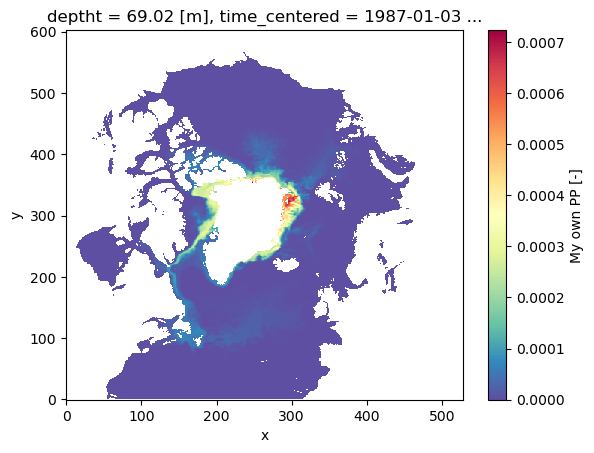

In [19]:
ds_AW.MyTrc.isel(time_counter=0,deptht=20).plot(cmap='Spectral_r')

In [18]:
def moor_loc(All_box):
    for box in All_box:
            print(box)
            plt.scatter(box['lat_min'],box['lon_min'],3,marker='o', color='r')

/dev/shm/pbs.2888960.datarmor0/ipykernel_48606/768119356.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pal = plt.cm.get_cmap('binary')
/dev/shm/pbs.2888960.datarmor0/ipykernel_48606/768119356.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pal = plt.cm.get_cmap('binary')


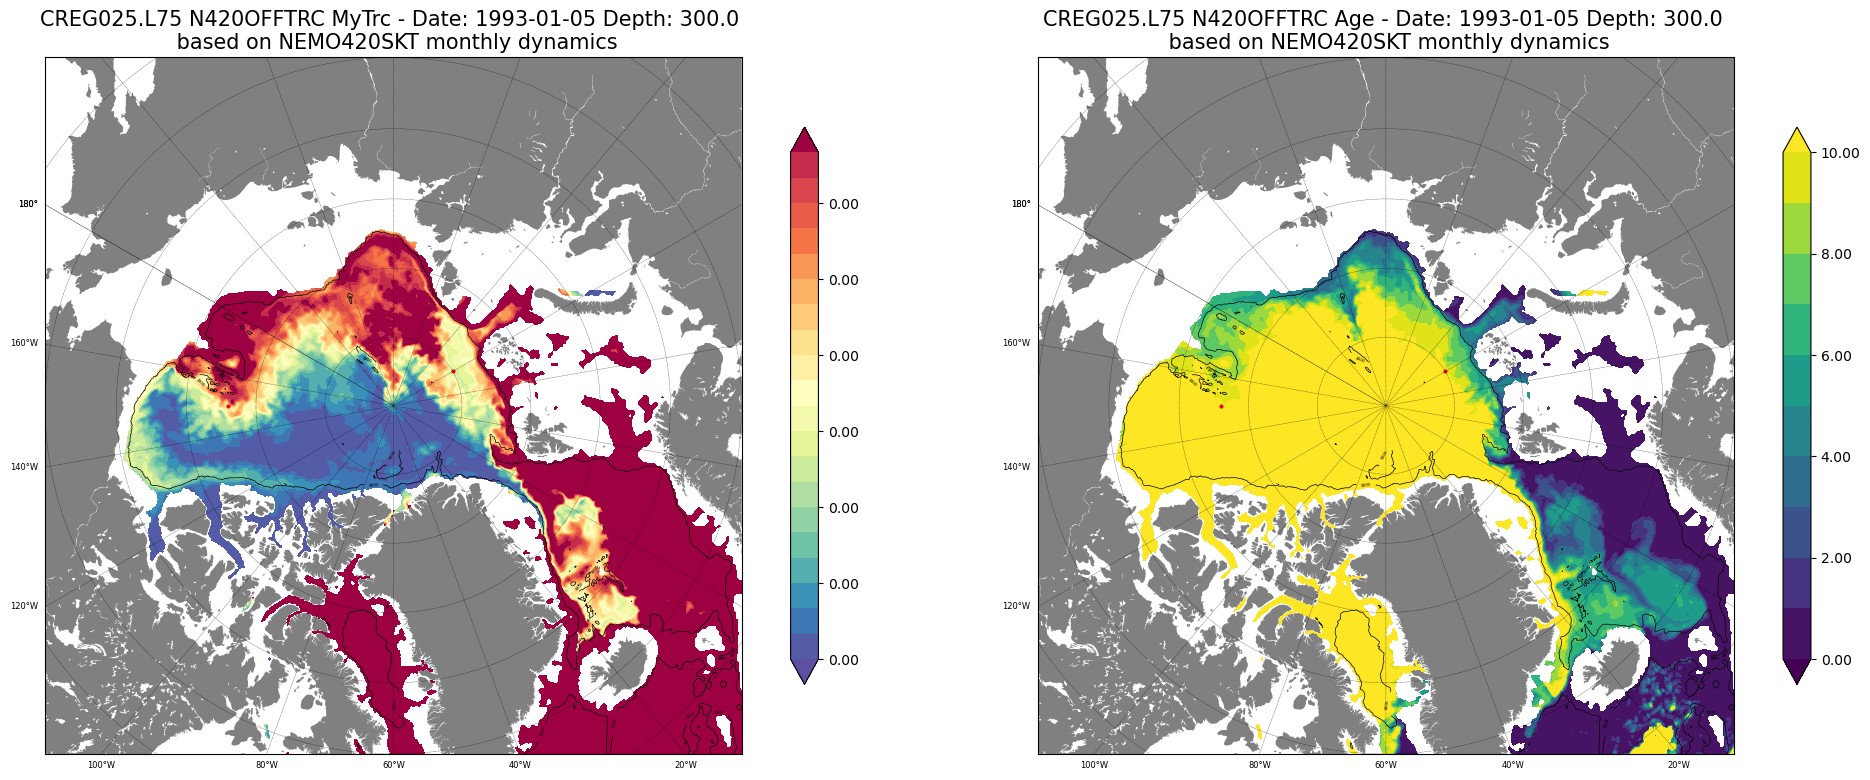

In [65]:
plt.figure(figsize=(20,15))

lyear='1993-01-05' 
ldepth=300.

plt.subplot(221)
# MyTrc
lcnt=21
vmin=0. ; vmax=1e-7
contours=np.arange(lcnt)*vmax
limits=[vmin,vmax*lcnt]

zfld=ds_AW.MyTrc.sel(time_counter=lyear,deptht=ldepth, method='nearest')
Arc_Bat()
m=Arc_plot(ds_AW.nav_lon,ds_AW.nav_lat,zfld,contours,limits,zmy_cblab=contours,zmy_cmap='Spectral_r')
plt.title('CREG025.L75 '+CASE+' MyTrc - Date: '+lyear+' Depth: '+str(ldepth)+' \n based on NEMO420SKT monthly dynamics',fontsize=15)

plt.subplot(222)
# Age
vmin=0. ; vmax=10.
contours=np.arange(vmax+1)
limits=[vmin,vmax]

zfld=ds_AW.Age.sel(time_counter=lyear,deptht=ldepth, method='nearest')
Arc_Bat()
m=Arc_plot(ds_AW.nav_lon,ds_AW.nav_lat,zfld,contours,limits,zmy_cblab=contours,zmy_cmap='viridis')
plt.title('CREG025.L75 '+CASE+' Age - Date: '+lyear+' Depth: '+str(ldepth)+' \n based on NEMO420SKT monthly dynamics',fontsize=15)

plt.tight_layout()

/dev/shm/pbs.2888960.datarmor0/ipykernel_48606/768119356.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pal = plt.cm.get_cmap('binary')
/dev/shm/pbs.2888960.datarmor0/ipykernel_48606/768119356.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pal = plt.cm.get_cmap('binary')


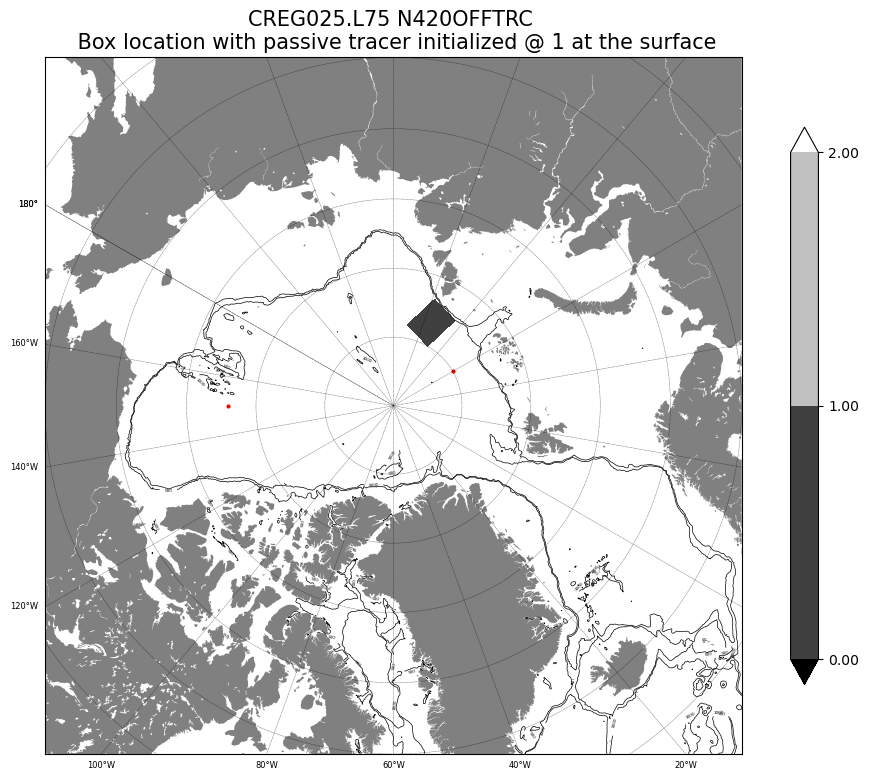

In [66]:
plt.figure(figsize=(20,15))

zero=np.full((ds_AW.dims['y'],ds_AW.dims['x']), np.nan)
ds_AW['MyTrc_ini']=(('y','x'),zero)
ds_AW['MyTrc_ini'][430:450,330:355]=1.

plt.subplot(221)
# MyTrc
lcnt=3
vmin=0. ; vmax=2.
contours=np.arange(lcnt)
limits=[vmin,vmax]
Arc_Bat()
Arc_Bat(ztype='isol500')
m=Arc_plot(ds_AW.nav_lon,ds_AW.nav_lat,ds_AW['MyTrc_ini'].data,contours,limits,zmy_cblab=contours,zmy_cmap='binary_r')
plt.title('CREG025.L75 '+CASE+' \n Box location with passive tracer initialized @ 1 at the surface',fontsize=15)


plt.tight_layout()

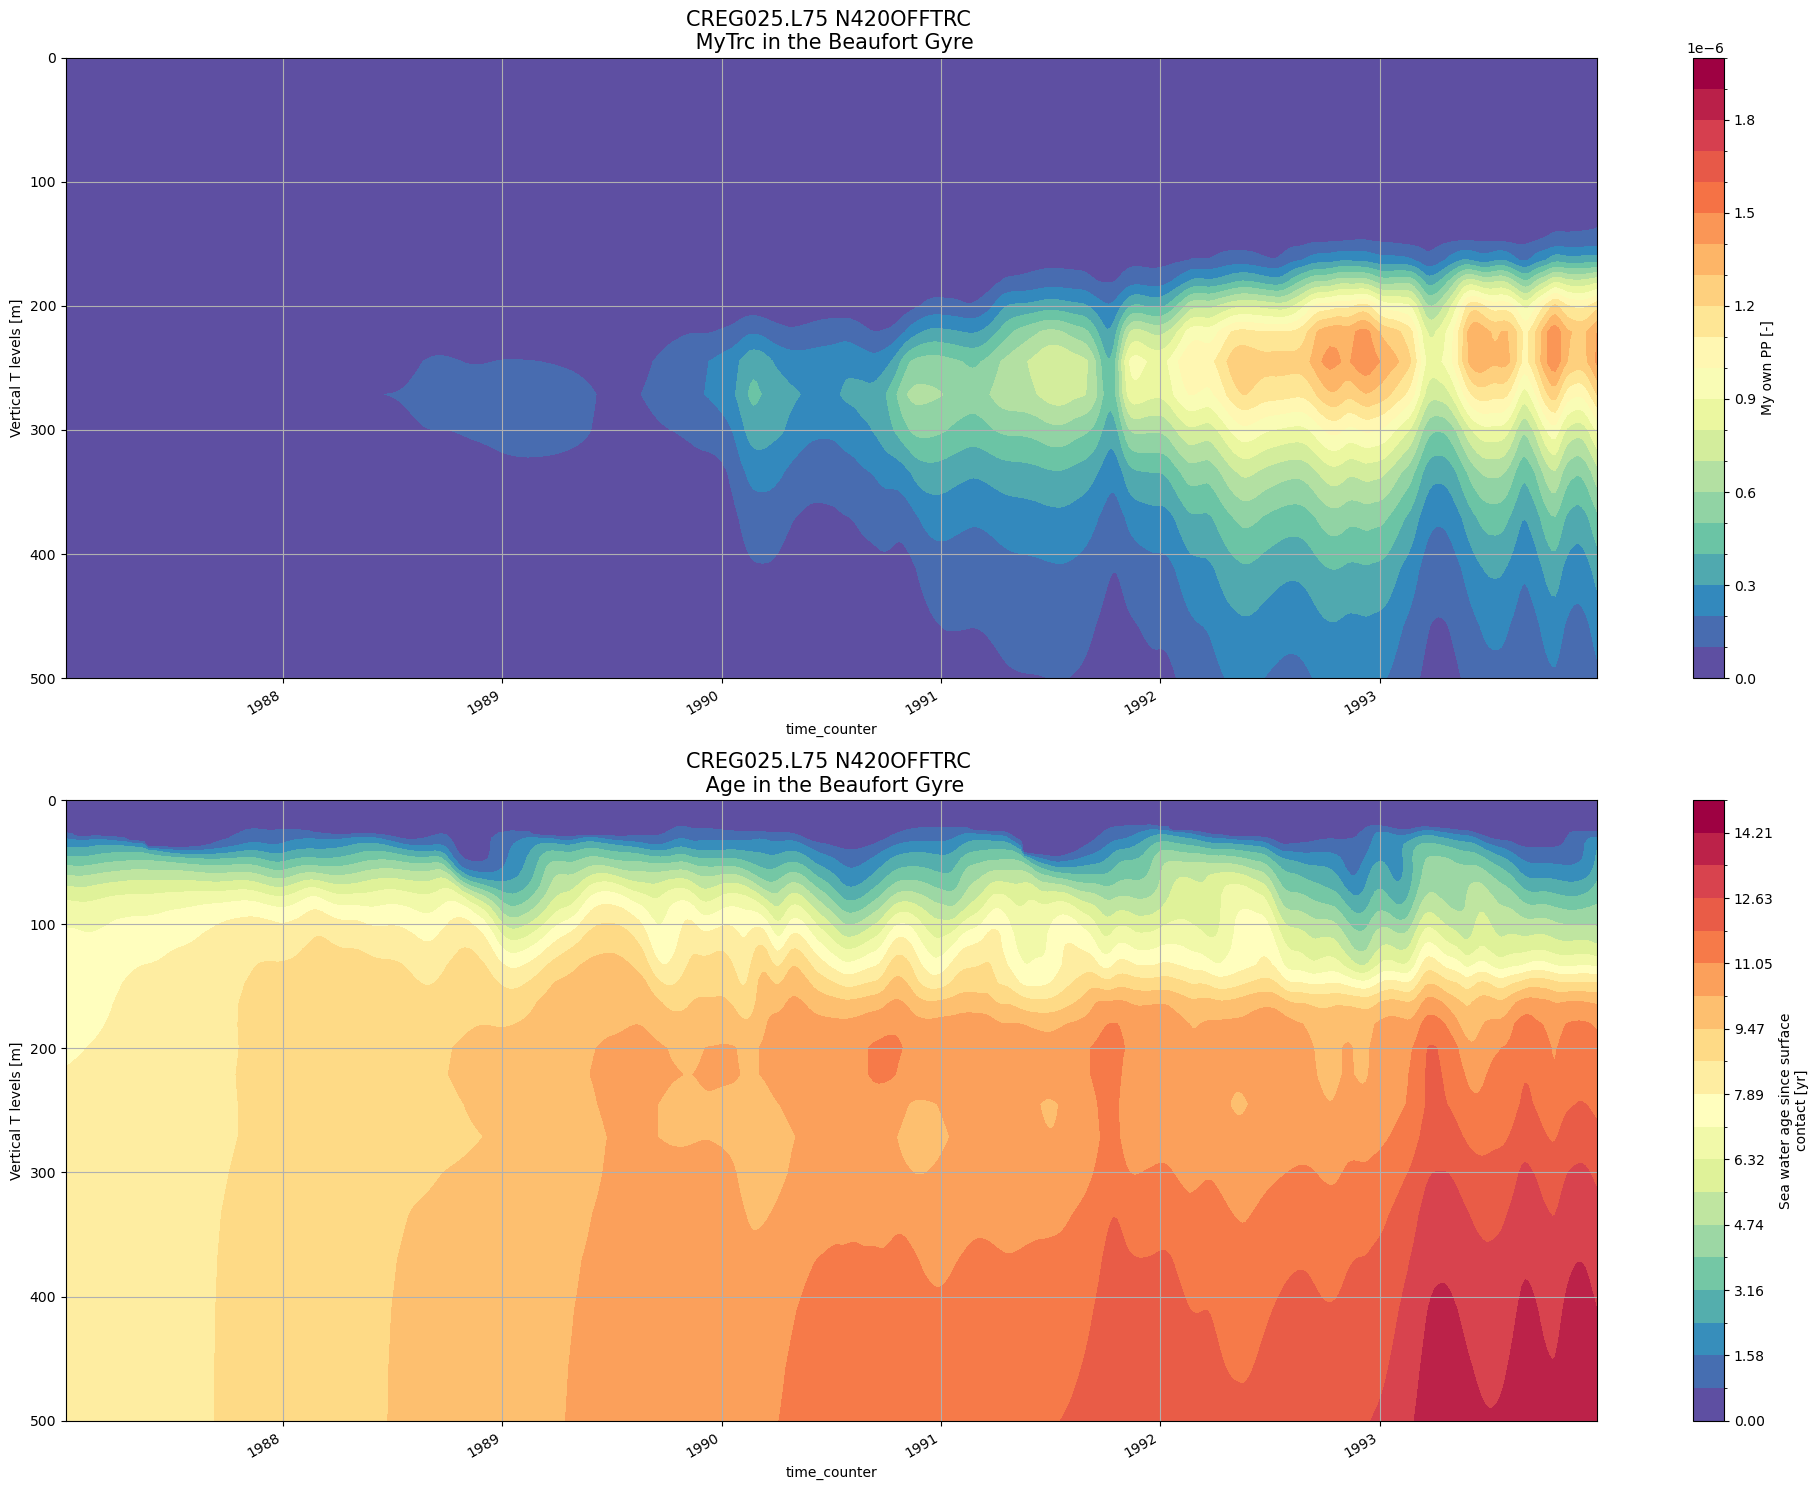

In [42]:
plt.figure(figsize=(20,15))

plt.subplot(211)
ds_AW.MyTrc.isel(x=200,y=500).plot.contourf(x='time_counter',y='deptht',yincrease=False,cmap='Spectral_r',levels=21,vmax=2e-6)
plt.title('CREG025.L75 '+CASE+' \n MyTrc in the Beaufort Gyre \n based on NEMO420SKT monthly dynamics',fontsize=15)
plt.xticks(size=10)
plt.yticks(size=10)
plt.grid(True)
plt.ylim([500.,0.])


plt.subplot(212)
ds_AW.Age.isel(x=200,y=500).plot.contourf(x='time_counter',y='deptht',yincrease=False,cmap='Spectral_r',levels=20,vmax=15.)
plt.title('CREG025.L75 '+CASE+' \n Age in the Beaufort Gyre \n based on NEMO420SKT monthly dynamics',fontsize=15)
plt.xticks(size=10)
plt.yticks(size=10)
plt.ylim([500.,0.])
plt.grid(True)

plt.tight_layout()

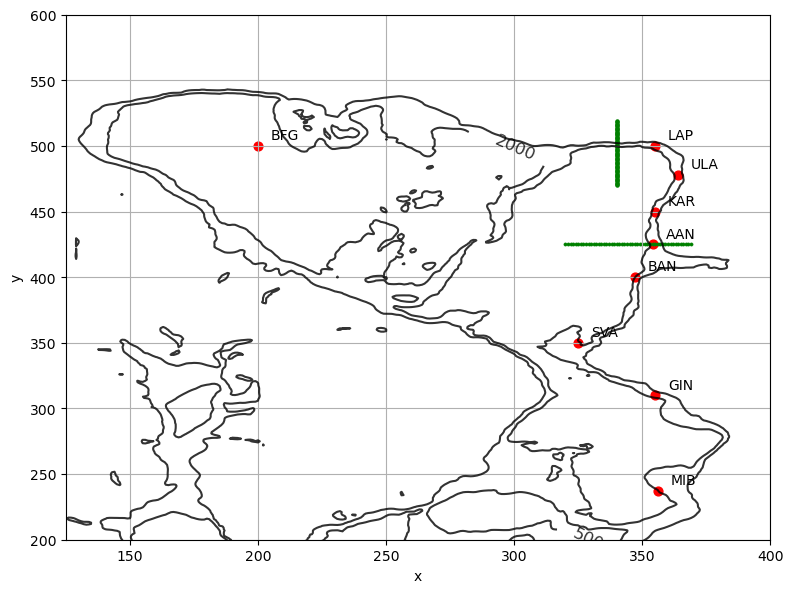

In [23]:
plt.figure(figsize=(20,15))
plt.subplot(221)
CS=fieldbat['bathy_meter'].isel(t=0).plot.contour(levels=[500.,2000.],colors='k',alpha=0.8)
plt.clabel(CS,fontsize=12)
plt.ylim([200,600])
plt.xlim([125,400])
All_box=[bx_SVAL,bx_BANN,bx_AANN,bx_KARA,bx_ULAP,bx_LAPT,bx_BGYR,bx_GINS,bx_MIKE]
for box in All_box:
    plt.scatter(box['lon_min'],box['lat_min'],40,marker='o', color='r')
    plt.text(box['lon_min']+5,box['lat_min']+5,box['name'])
plt.grid(True)
# Plot the sections
if True:
    All_sec=[SANX_sec]
    for box in All_sec:
            #################
            # ZONAL SECTIONS
            #################
            ji=box['imin'] ;   jj=box['jmax']
            while ji <= box['imax']-1 :
                    plt.scatter(ji,jj,5,linewidth=0.5,color='g')
                    ji+=1

    All_sec=[LAPT_sec]
    for box in All_sec:
            #################
            # MERIDIONAL SECTIONS
            #################
            jj=box['jmin'] ;       ji=box['imin']
            while jj <= box['jmax']-1 :
                    plt.scatter(ji,jj,5,linewidth=1,color='g')
                    jj+=1
